In [1]:
import numpy as np
import random
from math import pi, sqrt
import sys
import os.path
import matplotlib.pyplot as plt
import time

In [2]:
# generates single particle states
def wf_gen(N,N_pt,BC,t1,t2):
    h1=np.ones(N-1)
    h1[0::2]=0
    h2=np.ones(N-1)
    h2[1::2]=0
#     print(h1,h2)
    hop= np.diag(t1*h1+t2*h2+0j,1)
    hop[N-1,0]= t1*BC
    H_t= -(hop+ np.matrix(hop).H)/2 
    energies, evecs= np.linalg.eigh(H_t)
    return evecs[:,:N_pt]

def exact_renyi_calc(r,GA,epsilon=1e-9):
    chi0, _ =np.linalg.eigh(GA)
    chi1=chi0[np.nonzero(np.abs(chi0)>epsilon)]
    chi2=chi1[np.nonzero(np.abs(chi1-1)>epsilon)]
#     return -np.sum((1-chi2)*np.log(1-chi2)+chi2*np.log(chi2))
    return np.sum(np.log((1-chi2)**r+chi2**r))/(1-r)


# VMC function 
def VMC_main(r,numconfig,V1,wf_r,N,inds_A,N_pt,\
             n_occ_r,n_pos_r,coords_r):

    move_attempted = 0
    move_accepted = 0
    
    # possible steps
    step_abs=np.arange(1,Ns+1)
    step_vals=np.sort(np.concatenate((-step_abs,step_abs),axis=0)).tolist()


    inv_wf_r= np.zeros(wf_r.shape,dtype=np.complex128)
    for i_r in range(r):
        inv_wf_r[:,:,i_r]=np.linalg.inv(wf_r[:,:,i_r])

    count_comp=0
    count=0 # counter for energy
    howoften=10 # calculate energy every 10 steps
    min_step=500
    
#     ratio=np.zeros((numconfig,),dtype=np.complex64)
#     E_t=np.zeros(int(numconfig/howoften),dtype=np.complex64) # total energy
#     ent_ratio=np.zeros(int(numconfig/howoften),dtype=np.complex64) # total energy
    ent_ratio=np.zeros(numconfig,dtype=np.complex64) # total energy

    
    for step in range(numconfig+min_step):
        for i_r in range(r):
            
            for moved_elec in range(N_pt):
                move_attempted=move_attempted+1

                # random walk of Ns steps left or right
                stepx=random.sample(step_vals,1)[0]
                ptcls_x= np.mod( coords_r[moved_elec,i_r]+stepx, N) # new configuration

                if n_occ_r[ptcls_x,i_r]==1:
                    continue

                pt_wf_1=np.transpose(V1[ptcls_x,:])
                rel=np.dot(inv_wf_r[moved_elec,:,i_r],pt_wf_1)

                alpha=min(1, np.abs(rel)**2)

                random_num=random.random()

                if random_num <= alpha:
                    u_1=np.reshape(pt_wf_1,(N_pt,1)) - np.reshape(wf_r[:,moved_elec,i_r],(N_pt,1))
                    v=np.zeros((N_pt,1))
                    v[moved_elec]=1
                    inv_wf_r[:,:,i_r]=inv_wf_r[:,:,i_r] - np.dot(np.dot(np.dot(inv_wf_r[:,:,i_r],u_1),v.T),inv_wf_r[:,:,i_r]) \
                                     /(1+np.dot(v.T,np.dot(inv_wf_r[:,:,i_r],u_1))) 
                    wf_r[:,moved_elec,i_r]=np.reshape(pt_wf_1,(N_pt,))
    #                 inv_wf_1=np.linalg.inv(wf_1)

                    move_accepted=move_accepted+1
                    n_occ_r[coords_r[moved_elec,i_r],i_r]= 0
                    n_pos_r[coords_r[moved_elec,i_r],i_r]= 0

                    coords_r[moved_elec,i_r]=ptcls_x
                    n_occ_r[ptcls_x,i_r]= n_occ_r[ptcls_x,i_r]+1
                    n_pos_r[ptcls_x,i_r]= moved_elec+1

            x=np.argwhere(n_pos_r[:,i_r]>0)
            assert len(x)== N_pt, 'no of ptcle is %d' % (len(x))
            assert np.sum(n_occ_r[:,i_r])== N_pt, 'n_occ anc ptcle is %d' % (np.sum(n_occ_r[:,i_r]))

# ##############################################################
            
        if step> (min_step-1):
#             if ((step-min_step+1)%howoften)==0:
            number_pt_inside_A= np.sum(n_occ_r[inds_A,:],axis=0)
            if np.max(number_pt_inside_A)==np.min(number_pt_inside_A) :
                wf_inds= np.zeros((number_pt_inside_A[0],r),dtype=int)

                for i_r in range(r):
                    pt_num_inside = np.argwhere( n_occ_r[inds_A,i_r]>0 )
                    pt_num_inside = np.reshape( pt_num_inside, (len(pt_num_inside),)).tolist()
                    wf_inds[:,i_r]=( n_pos_r[ inds_A[pt_num_inside],i_r ] )-1

                wf_swap = np.zeros(wf_r.shape,dtype=np.complex128)
                for i_r in range(r-1):
                # r permutation of subsystem indices
                    wf_swap[:,:,i_r] = np.copy(wf_r[:,:,i_r])
                    wf_swap[:,wf_inds[:,i_r],i_r] = np.copy(wf_r[:,wf_inds[:,i_r+1],i_r+1])

                wf_swap[:,:,r-1] = np.copy(wf_r[:,:,r-1])
                wf_swap[:,wf_inds[:,r-1],r-1] = np.copy(wf_r[:,wf_inds[:,0],0])

                ratio_r=1.0
                for i_r in range(r):
                    ratio_r *= np.linalg.det(wf_swap[:,:,i_r])/np.linalg.det(wf_r[:,:,i_r])
                ent_ratio[step-min_step] = ratio_r
    #                     ent_ratio[count] = ratio_r
                count_comp+=1
            else:
                ent_ratio[step-min_step] = 0
    #                     ent_ratio[count] = 0
    #                 count+=1

        if (step%500) ==0:
            for i_r in range(r):
                inv_wf_r[:,:,i_r]=np.linalg.inv(wf_r[:,:,i_r])


    acc_ratio=move_accepted/move_attempted
    
#     print('MC result is ', -np.log(np.mean(ent_ratio)))
#     plt.figure()
#     plt.plot(np.real(ent_ratio),'o')
#     plt.show()
    print("Renyi computed %d times" % (count_comp))
    print("Acceptance rate=", acc_ratio)
    return  (np.log(np.mean(ent_ratio)))/(1-r)


# initialize wavefunction 
def initialize_wf(N,N_pt):
    coords=np.sort(random.sample(range(N),N_pt))
    n_occ=np.zeros((N,))        
    n_occ[coords]=np.ones((N_pt,))        
    n_pos = np.zeros((N,),dtype=int)        
    n_pos[coords] = np.arange(1,N_pt+1)
    
    return n_occ, n_pos, coords[:N_pt]


In [3]:
scratch="output_files/"

r=3 # Renyi index
# system size
N=20
# Lsub_list=np.arange(0,N+1)
Lsub_list=np.arange(2,11,2)
# Lsub_list=[6]
N_pt = int(N/2)
Ns=4 # number of steps of random walker

# reference slater determinant
t= -0.
# hopping amplitudes
t1= 1-t
t2= 1+t
BC=np.exp(1j*pi) # boundary condition on a chain, you can put BC=0 for open chain
# BC=1 periodic boundary condition and BC=-1 is anti-periodic
# do not put BC=1 since the gs is not unique in that case
V1=wf_gen(N,N_pt,BC,t1,t2) # eigenvectors in 

# print('exact result is ', R2_ex[0])

numconfig=40000
t_timer=time.time()

random.seed(time.time())

Rr_ex=np.zeros(len(Lsub_list)) # Renyi entropy
RNr_ex=np.zeros(len(Lsub_list)) # Renyi negativity
LN_ex=np.zeros(len(Lsub_list)) # Log negativity

Rr_vmc=np.zeros(len(Lsub_list), dtype=np.complex64)
Gmat=np.dot(V1,np.matrix(V1).H)

for i_L in range(len(Lsub_list)):
    Lsub=Lsub_list[i_L]
    print('subsystem size = ', Lsub)
    inds_A= np.arange(0,Lsub_list[i_L])

    Rr_ex[i_L]=exact_renyi_calc(r,Gmat[np.ix_(inds_A,inds_A)])
    
    # ##### initialization
    wf_r= np.zeros((N_pt,N_pt,r),dtype=np.complex64)
    n_occ_r= np.zeros((N,r),dtype=int)
    n_pos_r= np.zeros((N,r),dtype=int)
    coords_r= np.zeros((N_pt,r),dtype=int)
    
    cond_r= np.zeros(r)
    for i_r in range(r):
        n_occ_r[:,i_r], n_pos_r[:,i_r], coords_r[:,i_r]=initialize_wf(N, N_pt)
        wf_r[:,:,i_r]=np.transpose(V1[coords_r[:,i_r],:])
        cond_r[i_r]=np.linalg.cond(wf_r[:,:,i_r])
    
    counter=0
    epsilon= 1e-8
    while np.max(cond_r) > 1/epsilon :
        counter+=1
        assert counter<=40, "wave function cannot be constructed!"
        for i_r in range(r):
            n_occ_r[:,i_r], n_pos_r[:,i_r], coords_r[:,i_r]=initialize_wf(N, N_pt)
            wf_r[:,:,i_r]=np.transpose(V1[coords_r[:,i_r],:])
            cond_r[i_r]=np.linalg.cond(wf_r[:,:,i_r])

    Rr_vmc[i_L]=VMC_main(r,numconfig,V1,wf_r,N,inds_A,N_pt,\
                         n_occ_r,n_pos_r,coords_r)

elapsed = time.time() - t_timer
print("VMC finished, elapsed time =", elapsed, "sec")


subsystem size =  2
Renyi computed 14516 times
Acceptance rate= 0.2666962962962963
subsystem size =  4
Renyi computed 11084 times
Acceptance rate= 0.2668559670781893
subsystem size =  6
Renyi computed 10208 times
Acceptance rate= 0.26680658436213994
subsystem size =  8
Renyi computed 9667 times
Acceptance rate= 0.26638518518518517
subsystem size =  10
Renyi computed 9607 times
Acceptance rate= 0.2667045267489712
VMC finished, elapsed time = 298.06539702415466 sec


vmc:  [0.5760811 -3.5150133e-10j 0.7517906 -8.0759138e-10j
 0.83238465-5.1560256e-10j 0.8758246 -5.7013144e-10j
 0.8898565 +2.6826760e-10j]
exact:  [0.58613135 0.75233606 0.83367605 0.87435219 0.88689845]
error [%]: [1.7146759  0.07250421 0.15490451 0.16839713 0.3335295 ]


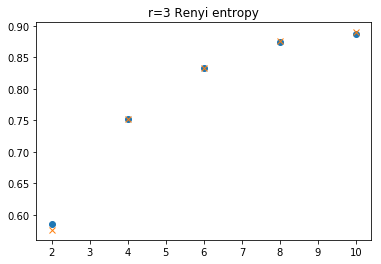

In [4]:
print('vmc: ', Rr_vmc)
print('exact: ', Rr_ex)
print('error [%]:', np.abs(Rr_vmc-Rr_ex)/Rr_ex*100)
plt.figure()
plt.plot(Lsub_list,Rr_ex,'o')
plt.plot(Lsub_list,np.real(Rr_vmc),'x')
plt.title('r=%d Renyi entropy' % (r))
plt.show()